In [2]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

from modules import *
from train_test import *
from models import *

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
tr_data = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
te_data = MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_data = torch.utils.data.DataLoader(dataset=tr_data, batch_size=64, shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=te_data, batch_size=64, shuffle=True)

In [4]:
class ProjConv(nn.Module):
    def __init__(self, d):
        super(ProjConv, self).__init__()
        
        self.basis_weights = nn.Parameter(torch.zeros(d, 1))
        self.d = d
        
        self.conv1 = Conv2dRP(in_channels=1, out_channels=16, kernel_size=3, padding=1, d=d)
        self.bn1 = BatchNorm2dRP(num_features=16, d=d)
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(2) #14x14
        
        self.conv2 = Conv2dRP(in_channels=16, out_channels=32, kernel_size=3, padding=1, d=d)
        self.bn2 = BatchNorm2dRP(num_features=32, d=d)
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(2) #7x7
        
        self.av = nn.AvgPool2d(7)
        self.lin1 = LinearRP(32, 10, d=d)
        
    def forward(self, x):
        
        x=self.conv1(x, self.basis_weights)
        x =self.bn1(x, self.basis_weights)
        x=self.relu1(x)
        x=self.mp1(x)
        x=self.conv2(x, self.basis_weights)
        x =self.bn2(x, self.basis_weights)
        x=self.relu2(x)
        x=self.mp2(x)
        
        x=self.av(x)
        x=self.lin1(x.view(x.size(0),-1), self.basis_weights)
        
        return x

In [6]:
model_rp = ProjConv
opt = torch.optim.Adam
criterion = nn.CrossEntropyLoss()

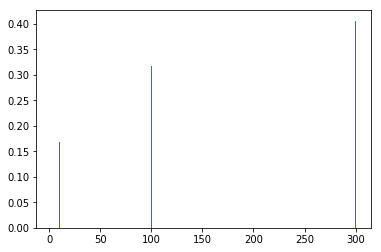

4it [10:34, 158.56s/it]


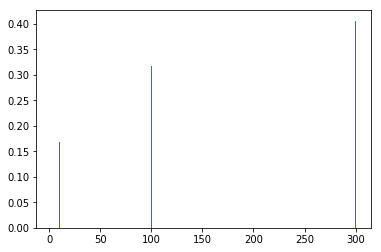

In [7]:
a, b = Dgrid_train(network_class=model_rp, 
                   network_args={'d':None}, 
                   optimizer_class=opt, 
                   optimizer_args={'lr':0.001},
                   criterion=criterion, 
                   train_data=train_data, 
                   test_data=test_data, 
                   epoches=3, 
                   flatten = False,
                   d_range=[3,10,100,300], 
                   verbose=True)